In [298]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/Users/zhangkewen/Documents/scripts/prl-coreas-zhaires-main/')
import AiresInfoFunctions as Aires
import math
from scipy.signal import hilbert

In [330]:
def get_shower_plane(k,B,vector):
    kxB=np.cross(k,B)
    kxB/= np.linalg.norm(kxB)
    kxkxB=np.cross(k,kxB)
    kxkxB/=np.linalg.norm(kxkxB)
    return np.array([np.dot(kxB,vector),np.dot(kxkxB,vector),np.dot(k,vector)])


def get_geo_ce(f_vxB,f_vxvxB,phi):
    sel= abs(np.sin(phi))>0.01
    f_geo=np.square(np.sqrt(f_vxB[sel]) - (np.cos(phi[sel]) / np.abs(np.sin(phi[sel]))) * np.sqrt(f_vxvxB[sel]))
    f_ce=f_vxvxB[sel]/np.square(np.sin(phi[sel]))
    return f_geo,f_ce

def get_normalized_angle(angle, degree=False, interval=np.deg2rad([0, 360])):
    import collections.abc
    if degree:
        interval = np.rad2deg(interval)
    delta = interval[1] - interval[0]
    if(isinstance(angle, (collections.abc.Sequence, np.ndarray))):
        angle[angle >= interval[1]] -= delta
        angle[angle < interval[0]] += delta
    else:
        while (angle >= interval[1]):
            angle -= delta
        while (angle < interval[0]):
            angle += delta
    return angle




In [272]:
path_dir='/Users/zhangkewen/Documents/data/grand/zhaires_sim/Stshp_MZS_QGS204JET_Proton_3.98_64.0_45.0_8/'
pos_file=path_dir+'antpos.dat'
pos = np.genfromtxt(pos_file, usecols=(2, 3, 4))
pos=pos[0:160,:]
n=len(pos[:,0])
n_samples=1999
times = np.zeros((n, n_samples))
traces = np.zeros((n, 3, n_samples))
for idx in range(160):
    ant_path = os.path.join(path_dir,path_dir.split('/')[-2], f"a{idx}.trace") 
    data = np.genfromtxt(ant_path)
    t = data[:, 0] * 1e-9
    trace = data[:, 1:]  * 1e-6 
    times[idx] = t
    traces[idx] = trace.T
    
spec = np.fft.rfft(traces, axis=-1)
filtered_spec=np.zeros((160,3,1000),dtype='complex')
for i in range(160):
    filtered_spec[i,:,50:200]=spec[i,:,50:200]
filt = np.fft.irfft(filtered_spec,1999,axis=-1)


In [320]:
sryfile=os.path.join(path_dir,path_dir.split('/')[-2]+'.sry') 
zenith=float(path_dir.split('/')[-2].split('_')[-3])*np.pi/180
azimuth =float(path_dir.split('/')[-2].split('_')[-2])*np.pi/180
_,BFieldIncl,_=Aires.GetMagneticFieldFromSry(sryfile)
BFieldIncl = np.pi / 2 + np.deg2rad(BFieldIncl)
BFieldDecl=0
B_field=np.array([np.cos(BFieldDecl) * np.sin(BFieldIncl),np.sin(BFieldDecl) * np.sin(BFieldIncl),np.cos(BFieldIncl)])
k_shower =-np.array([np.cos(azimuth) * np.sin(zenith),np.sin(azimuth) * np.sin(zenith),np.cos(zenith)])

XmaxAltitude,  XmaxDistance,x_xmax, y_xmax, z_xmax=Aires.GetKmXmaxFromSry(sryfile)


In [333]:
core_pos=np.array([0,0,2100])
pos_shower_plane=get_shower_plane(k_shower,B_field,(pos-core_pos).T)
traces_shower_plane = np.array([get_shower_plane(k_shower,B_field,trace) for trace in filt])
phi =get_normalized_angle(np.arctan2(pos_shower_plane[1,:], pos_shower_plane[0,:]))
arms = np.unique(np.around(np.rad2deg(phi), 0))


In [334]:
ant2Xmax_dis=np.dot(pos,k_shower)
XmaxDis=XmaxDistance*1e3
early_late=np.square((XmaxDis+ant2Xmax_dis)/XmaxDis)
fluences_shower_plane=np.array([np.sum(trace**2, axis=-1) for trace in traces_shower_plane ])#calculate_energy_fluence(traces_shower_plane)#
f_tot = np.sum(fluences_shower_plane,axis=-1)*early_late
f_geo,f_ce=get_geo_ce(fluences_shower_plane[:,0]*early_late,fluences_shower_plane[:,1]*early_late,phi)

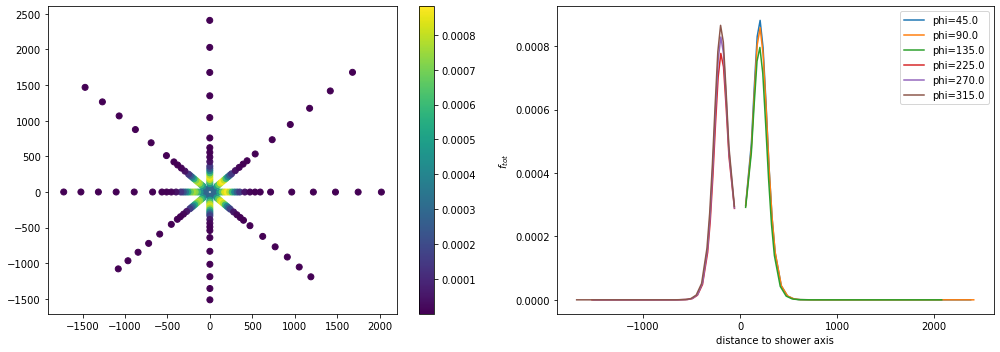

In [335]:
#total fluence
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(pos_shower_plane[0,:],pos_shower_plane[1,:],c=f_tot)
plt.colorbar()
plt.subplot(1,2,2)
d2r = np.sqrt(pos_shower_plane[0,:] ** 2 + pos_shower_plane[1,:] ** 2)
phi_deg = np.around(np.rad2deg(phi), 0)
for phii in np.unique(phi_deg[~vxB_axis]):
    plt.plot(d2r[phi_deg == phii] * np.sign(pos_shower_plane[1,:][phi_deg == phii]), f_tot[phi_deg == phii],label='phi=' + str(phii))
    
plt.xlabel(r"distance to shower axis")
plt.ylabel(r"$f_{tot}$")
plt.legend()
plt.tight_layout()
    

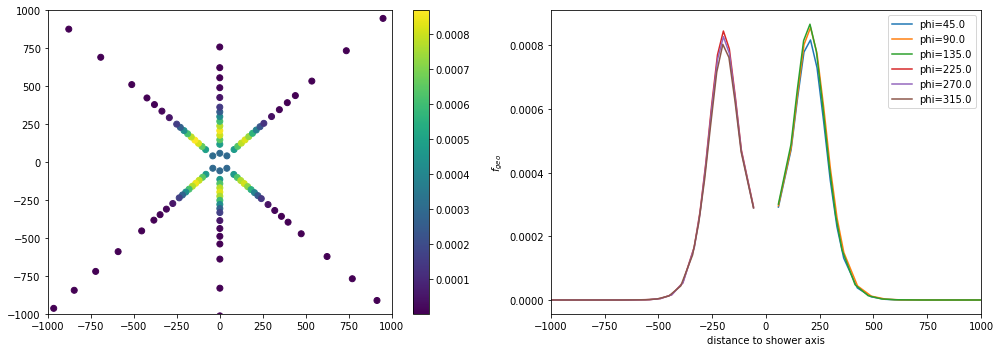

In [336]:
#geomagnetic fluence
vxB_axis = np.abs(np.sin(phi)) < 0.01
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(pos_shower_plane[0,~vxB_axis],pos_shower_plane[1,~vxB_axis],c=f_geo)
plt.colorbar()
plt.xlim([-1000,1000])
plt.ylim([-1000,1000])
plt.subplot(1,2,2)
for phii in np.unique(phi_deg[~vxB_axis]):
    plt.plot(d2r[phi_deg == phii] * np.sign(pos_shower_plane[1,:][phi_deg == phii]), f_geo[phi_deg[~vxB_axis] == phii],label='phi=' + str(phii))
    
plt.xlabel(r"distance to shower axis")
plt.ylabel(r"$f_{geo}$")
plt.legend()
plt.xlim([-1000,1000])
plt.tight_layout()

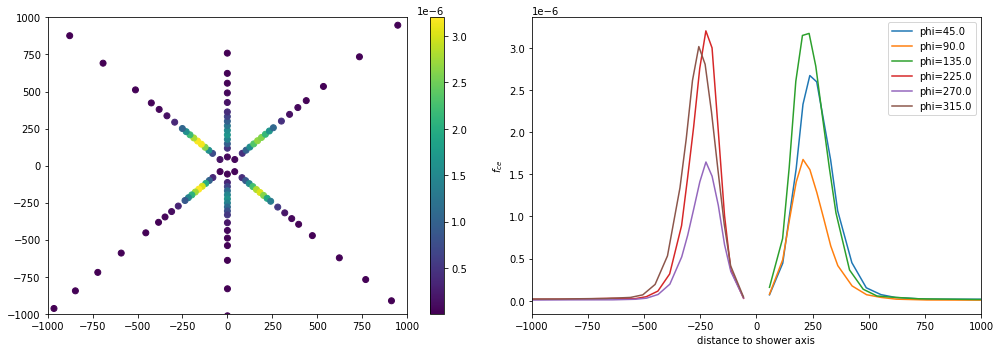

In [337]:
#charge excess fluence
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(pos_shower_plane[0,~vxB_axis],pos_shower_plane[1,~vxB_axis],c=f_ce)
plt.colorbar()
plt.xlim([-1000,1000])
plt.ylim([-1000,1000])
plt.subplot(1,2,2)
for phii in np.unique(phi_deg[~vxB_axis]):
    plt.plot(d2r[phi_deg == phii] * np.sign(pos_shower_plane[1,:][phi_deg == phii]), f_ce[phi_deg[~vxB_axis] == phii],label='phi=' + str(phii))
    
plt.xlabel(r"distance to shower axis")
plt.ylabel(r"$f_{ce}$")
plt.legend()
plt.xlim([-1000,1000])
plt.tight_layout()